## Create a single, two-panel figure summarizing the DepMap dataset

| Panel | Description | Importance | Plot type |
| :---: | :---------: | :--------: | :-------: |
| A     | Distribution of ages | How many pediatric vs adult cancers | Histogram |
| B     | Distribution of pediatric cancer types by sex | View how many pediatric cancer types of each | Bar |

In [1]:
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(cowplot))

Warning message:
“package ‘ggplot2’ was built under R version 4.2.3”
Warning message:
“package ‘cowplot’ was built under R version 4.2.3”


In [2]:
# Set i/o paths and files
data_dir <- file.path("../0.data-download/data")
fig_dir <- file.path("figures")

model_input_file <- file.path(data_dir, "Model.parquet")
crispr_input_file <- file.path(data_dir, "CRISPRGeneEffect.parquet")

figure_output_file <- file.path(fig_dir, "age_and_ped_model_distributions.png")

In [3]:
# Set figure sizes
text_size = 9

In [4]:
# Process dataset
model_df <- readr::read_parquet(
    model_input_file,
    col_types = readr::cols(
        .default = "c",
        Age = "d"
    )
)

print(dim(model_df))

crispr_df <- readr::read_parquet(
    crispr_input_file,
    col_types = readr::cols(
        .default = "d",
        ModelID = "c"
    )
)

print(dim(crispr_df))

# Get common depmap identifiers
common_depmap_ids <- intersect(model_df$ModelID, crispr_df$ModelID)

# Subset the model dataframe to only those we have dependency data for
model_df <- model_df %>%
    dplyr::filter(ModelID %in% common_depmap_ids)

# The updated dimensions should be the same as crispr_df
print(dim(model_df))

# Show model_df
head(model_df, 3)

ERROR: Error: 'read_parquet' is not an exported object from 'namespace:readr'


In [ ]:
colnames(model_df)

[1] "ModelID"                  "PatientID"               
 [3] "CellLineName"             "StrippedCellLineName"    
 [5] "DepmapModelType"          "OncotreeLineage"         
 [7] "OncotreePrimaryDisease"   "OncotreeSubtype"         
 [9] "OncotreeCode"             "LegacyMolecularSubtype"  
[11] "LegacySubSubtype"         "PatientMolecularSubtype" 
[13] "RRID"                     "Age"                     
[15] "AgeCategory"              "Sex"                     
[17] "PatientRace"              "PrimaryOrMetastasis"     
[19] "SampleCollectionSite"     "SourceType"              
[21] "SourceDetail"             "CatalogNumber"           
[23] "PatientTreatmentStatus"   "PatientTreatmentType"    
[25] "PatientTreatmentDetails"  "Stage"                   
[27] "StagingSystem"            "PatientTumorGrade"       
[29] "PatientTreatmentResponse" "GrowthPattern"           
[31] "OnboardedMedia"           "FormulationID"           
[33] "PlateCoating"             "EngineeredModel"         
[35] "TissueOrigin"             "ModelDerivationMaterial" 
[37] "PublicComments"           "CCLEName"                
[39] "HCMIID"                   "WTSIMasterCellID"        
[41] "SangerModelID"            "COSMICID"                
[43] "DateSharedIndbGaP"

## Age distribution

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
“Removed 217 rows containing non-finite outside the scale range (`stat_bin()`).”


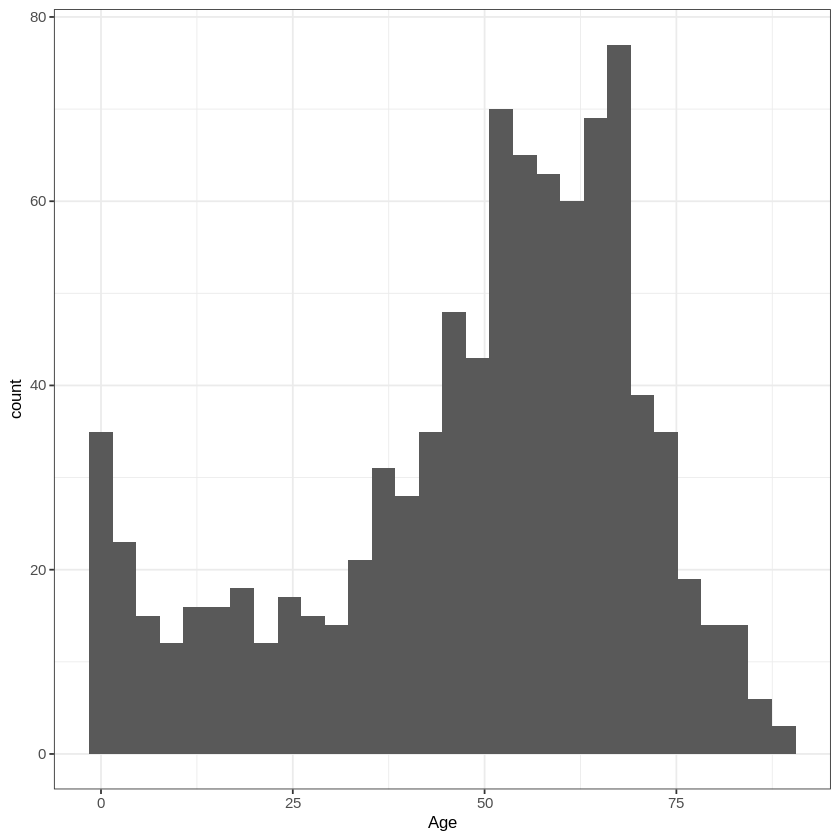

In [ ]:
age_distrib_gg = (
    ggplot(model_df, aes(x = Age))
    + geom_histogram()
    + theme_bw()
    + theme(
        axis.text = element_text(size = text_size),
        axis.title = element_text(size = text_size + 1)
    )
)

age_distrib_gg

In [ ]:
# Subset to pediatric cancers only
ped_model_df <- model_df %>%
    dplyr::filter(AgeCategory == "Pediatric")

In [ ]:
rev(sort(table(ped_model_df$OncotreePrimaryDisease)))


                                                                                      Neuroblastoma 
                                                                                                 35 
                                                                                      Ewing Sarcoma 
                                                                                                 15 
                                                                                    Embryonal Tumor 
                                                                                                 14 
                                                                                   Rhabdomyosarcoma 
                                                                                                 13 
                                                                                       Osteosarcoma 
                                                                                          

In [ ]:
disease_type_recode <- ped_model_df$OncotreePrimaryDisease %>%
    dplyr::recode(
        `Diffuse Glioma` = "Other/Rare (13 unique)",
        `Epithelioid Sarcoma` = "Other/Rare (13 unique)",
        `Melanoma` = "Other/Rare (13 unique)",
        `Myeloproliferative Neoplasms` = "Other/Rare (13 unique)",
        `Ovarian Epithelial Tumor` = "Other/Rare (13 unique)",
        `Ovarian Germ Cell Tumor` = "Other/Rare (13 unique)",
        `Undifferentiated Pleomorphic Sarcoma/Malignant Fibrous Histiocytoma/High-Grade Spindle Cell Sarcoma` = "Other/Rare (13 unique)",
        `Hepatoblastoma` = "Other/Rare (13 unique)",
        `Renal Cell Carcinoma` = "Other/Rare (13 unique)",
        `Retinoblastoma` = "Other/Rare (13 unique)",
        `Rhabdoid Cancer` = "Other/Rare (13 unique)",
        `Synovial Sarcoma` = "Other/Rare (13 unique)",
        `T-Lymphoblastic Leukemia/Lymphoma` = "Other/Rare (13 unique)",
        `B-Lymphoblastic Leukemia/Lymphoma` = "B-ALL"
    )

ped_model_df <- ped_model_df %>%
    dplyr::mutate(disease_type_recoded = disease_type_recode)

ped_model_df$disease_type_recoded <- factor(
    ped_model_df$disease_type_recoded,
    levels = names(sort(rev(table(ped_model_df$disease_type_recoded))))
)

Warning message:
“A numeric `legend.position` argument in `theme()` was deprecated in ggplot2
3.5.0.
ℹ Please use the `legend.position.inside` argument of `theme()` instead.”


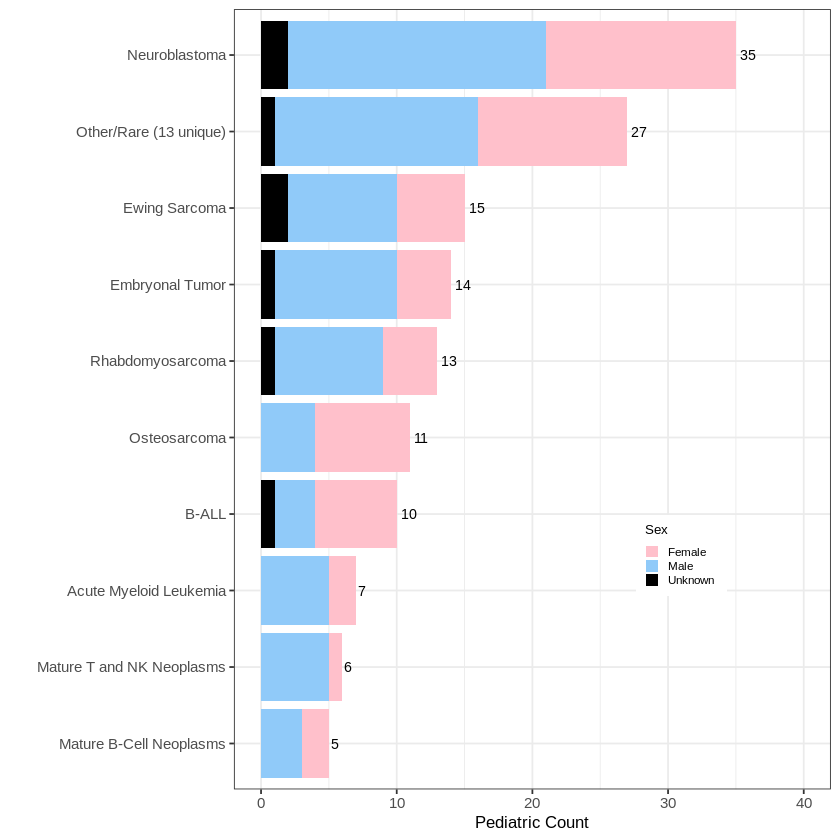

In [ ]:
cancer_type_distrib_gg = (
    ggplot(ped_model_df, aes(x = disease_type_recoded))
    + geom_bar(aes(fill = Sex), position = "stack")
    + coord_flip()
    + theme_bw()
    + geom_text(
        stat = "count",
        aes(label = after_stat(count)),
        vjust = 0.5,
        hjust = -0.25,
        size = 3
    )
    + scale_fill_manual(
        values = c(
            "Male" = "#90CAF9",
            "Female" = "pink",
            "Unknown" = "black"
        )
    )
    + ylim(c(0, 40))
    + theme(
        axis.text = element_text(size = text_size),
        axis.title = element_text(size = text_size + 1),
        legend.text = element_text(size = text_size - 2),
        legend.title = element_text(size = text_size - 1),
        legend.position = c(0.75, 0.3),
        legend.key.size = unit(0.3, 'cm')
    )
    + labs(y = "Pediatric Count", x = "")
    + guides(fill = guide_legend(override.aes = list(size = 0.5)))
)

cancer_type_distrib_gg

In [ ]:
full_gg <- cowplot::plot_grid(
    age_distrib_gg,
    cancer_type_distrib_gg,
    labels = c("A", "B"),
    ncol = 2,
    rel_widths = c(0.45, 1)
)

ggsave(figure_output_file, full_gg, width = 4.75, height = 1.75, dpi = 500)

full_gg

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
“Removed 217 rows containing non-finite outside the scale range (`stat_bin()`).”
